## Data Visualization: Energy Consumption by DPE Rating

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import contextily as ctx
from scipy.stats import mstats

In [4]:
Data  = pd.read_csv('C:/Users/msi/Desktop/projetAgir/data/data-final.csv')
Data

,N°DPE,Etiquette_GES,Type_bâtiment,Classe_inertie_bâtiment,Adresse,Etiquette_DPE,N°_région_(BAN),Nom Commune,Code_postal_(brut),Conso_5_usages_é_finale_énergie_n°1,...,Température maximale,Température minimale,Date,Saison,Année_y,Température moyenne annuelle,Centile_25%,Centile_50% (Médiane),Centile_75%,Code Département
0,2374E0428703N,D,appartement,Très lourde,7 RUE DES CHARMILLES,D,84.0,annecy,74960,16482.9,...,8.6,2.2,2018-01-01,Hiver,2018,12.083333,4.875,12.55,18.375,74.0
1,2374E0428703N,D,appartement,Très lourde,7 RUE DES CHARMILLES,D,84.0,annecy,74960,16482.9,...,4.0,-1.1,2018-02-01,Hiver,2018,12.083333,4.875,12.55,18.375,74.0
2,2374E0428703N,D,appartement,Très lourde,7 RUE DES CHARMILLES,D,84.0,annecy,74960,16482.9,...,10.7,1.4,2018-03-01,Printemps,2018,12.083333,4.875,12.55,18.375,74.0
3,2374E0428703N,D,appartement,Très lourde,7 RUE DES CHARMILLES,D,84.0,annecy,74960,16482.9,...,20.9,6.8,2018-04-01,Printemps,2018,12.083333,4.875,12.55,18.375,74.0
4,2374E0428703N,D,appartement,Très lourde,7 RUE DES CHARMILLES,D,84.0,annecy,74960,16482.9,...,21.9,10.7,2018-05-01,Printemps,2018,12.083333,4.875,12.55,18.375,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90011,2386E3704884Y,C,appartement,Lourde,16 RUE HENRI DUNANT,C,75.0,poitiers,86000,8390.0,...,27.1,14.9,2023-08-01,Été,2023,13.583333,8.925,13.10,20.275,86.0
90012,2386E3704884Y,C,appartement,Lourde,16 RUE HENRI DUNANT,C,75.0,poitiers,86000,8390.0,...,27.9,15.1,2023-09-01,Automne,2023,13.583333,8.925,13.10,20.275,86.0
90013,2386E3704884Y,C,appartement,Lourde,16 RUE HENRI DUNANT,C,75.0,poitiers,86000,8390.0,...,21.6,10.4,2023-10-01,Automne,2023,13.583333,8.925,13.10,20.275,86.0
90014,2386E3704884Y,C,appartement,Lourde,16 RUE HENRI DUNANT,C,75.0,poitiers,86000,8390.0,...,13.0,6.5,2023-11-01,Automne,2023,13.583333,8.925,13.10,20.275,86.0


In [5]:
Data.columns 

Index(['N°DPE', 'Etiquette_GES', 'Type_bâtiment', 'Classe_inertie_bâtiment',
       'Adresse', 'Etiquette_DPE', 'N°_région_(BAN)', 'Nom Commune',
       'Code_postal_(brut)', 'Conso_5_usages_é_finale_énergie_n°1',
       'Conso_chauffage_é_finale_énergie_n°1',
       'Type_énergie_principale_chauffage', 'Conso_chauffage_é_primaire',
       'Conso_5_usages_é_primaire', 'Chauffage_électrique', 'Année_x',
       'Code IRIS', 'Nom IRIS', 'Numéro de voie', 'Indice de répétition',
       'Type de voie', 'Libellé de voie', 'Code Commune', 'Segment de client',
       'Nombre de logements',
       'Consommation annuelle totale de l'adresse (MWh)',
       'Consommation annuelle moyenne par logement de l'adresse (MWh)',
       'Consommation annuelle moyenne de la commune (MWh)', 'Code EPCI',
       'Code Région', 'Tri des adresses', 'Température moyenne mensuelle',
       'Température maximale', 'Température minimale', 'Date', 'Saison',
       'Année_y', 'Température moyenne annuelle', 'Centile_2

In [6]:
print("\nUnique etiquette in DPE:", Data['Etiquette_DPE'].unique())


Unique etiquette in DPE: ['D' 'F' 'C' 'G' 'E' 'B' 'A']


In [7]:
# 1. Ordonner les classes DPE
dpe_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
Data['Etiquette_DPE'] = pd.Categorical(Data['Etiquette_DPE'], categories=dpe_order, ordered=True)

# 2. Gérer les valeurs extrêmes (outliers)
col_conso = "Consommation annuelle moyenne par logement de l'adresse (MWh)"
Data[col_conso] = mstats.winsorize(Data[col_conso], limits=[0.01, 0.01])

# 3. Regrouper les types de bâtiments rares
building_counts = Data['Type_bâtiment'].value_counts()
Data['Type_bâtiment'] = Data['Type_bâtiment'].where(building_counts[Data['Type_bâtiment']].values >= 50, 'Autres')

In [8]:
## dictionnaire numero de region -> nom de region
departements_regions_2016 = {
    # Auvergne-Rhône-Alpes
    '01': 'Auvergne-Rhône-Alpes',  # Ain
    '03': 'Auvergne-Rhône-Alpes',  # Allier
    '07': 'Auvergne-Rhône-Alpes',  # Ardèche
    '15': 'Auvergne-Rhône-Alpes',  # Cantal
    '26': 'Auvergne-Rhône-Alpes',  # Drôme
    '38': 'Auvergne-Rhône-Alpes',  # Isère
    '42': 'Auvergne-Rhône-Alpes',  # Loire
    '43': 'Auvergne-Rhône-Alpes',  # Haute-Loire
    '63': 'Auvergne-Rhône-Alpes',  # Puy-de-Dôme
    '69': 'Auvergne-Rhône-Alpes',  # Rhône (circonscription départementale)
    '69D': 'Auvergne-Rhône-Alpes',  # Rhône (hors métropole de Lyon)
    '69M': 'Auvergne-Rhône-Alpes',  # Métropole de Lyon
    '73': 'Auvergne-Rhône-Alpes',  # Savoie
    '74': 'Auvergne-Rhône-Alpes',  # Haute-Savoie
    
    # Bourgogne-Franche-Comté
    '21': 'Bourgogne-Franche-Comté',  # Côte-d'Or
    '25': 'Bourgogne-Franche-Comté',  # Doubs
    '39': 'Bourgogne-Franche-Comté',  # Jura
    '58': 'Bourgogne-Franche-Comté',  # Nièvre
    '70': 'Bourgogne-Franche-Comté',  # Haute-Saône
    '71': 'Bourgogne-Franche-Comté',  # Saône-et-Loire
    '89': 'Bourgogne-Franche-Comté',  # Yonne
    '90': 'Bourgogne-Franche-Comté',  # Territoire de Belfort
     
    # Bretagne
    '22': 'Bretagne',  # Côtes-d'Armor
    '29': 'Bretagne',  # Finistère
    '35': 'Bretagne',  # Ille-et-Vilaine
    '56': 'Bretagne',  # Morbihan
    
    # Centre-Val de Loire
    '18': 'Centre-Val de Loire',  # Cher
    '28': 'Centre-Val de Loire',  # Eure-et-Loir
    '36': 'Centre-Val de Loire',  # Indre
    '37': 'Centre-Val de Loire',  # Indre-et-Loire
    '41': 'Centre-Val de Loire',  # Loir-et-Cher
    '45': 'Centre-Val de Loire',  # Loiret
    
    # Corse
    '2A': 'Corse',  # Corse-du-Sud
    '2B': 'Corse',  # Haute-Corse
    
    # Grand Est
    '08': 'Grand Est',  # Ardennes
    '10': 'Grand Est',  # Aube
    '51': 'Grand Est',  # Marne
    '52': 'Grand Est',  # Haute-Marne
    '54': 'Grand Est',  # Meurthe-et-Moselle
    '55': 'Grand Est',  # Meuse
    '57': 'Grand Est',  # Moselle
    '67': 'Grand Est',  # Bas-Rhin
    '68': 'Grand Est',  # Haut-Rhin
    '88': 'Grand Est',  # Vosges
    
    # Hauts-de-France
    '02': 'Hauts-de-France',  # Aisne
    '59': 'Hauts-de-France',  # Nord
    '60': 'Hauts-de-France',  # Oise
    '62': 'Hauts-de-France',  # Pas-de-Calais
    '80': 'Hauts-de-France',  # Somme
    
    # Île-de-France
    '75': 'Île-de-France',  # Paris
    '77': 'Île-de-France',  # Seine-et-Marne
    '78': 'Île-de-France',  # Yvelines
    '91': 'Île-de-France',  # Essonne
    '92': 'Île-de-France',  # Hauts-de-Seine
    '93': 'Île-de-France',  # Seine-Saint-Denis
    '94': 'Île-de-France',  # Val-de-Marne
    '95': 'Île-de-France',  # Val-d'Oise
    
    # Normandie
    '14': 'Normandie',  # Calvados
    '27': 'Normandie',  # Eure
    '50': 'Normandie',  # Manche
    '61': 'Normandie',  # Orne
    '76': 'Normandie',  # Seine-Maritime
    
    # Nouvelle-Aquiitaine
    '16': 'Nouvelle-Aquitaine',  # Charente
    '17': 'Nouvelle-Aquitaine',  # Charente-Maritime
    '19': 'Nouvelle-Aquitaine',  # Corrèze
    '23': 'Nouvelle-Aquitaine',  # Creuse
    '24': 'Nouvelle-Aquitaine',  # Dordogne
    '33': 'Nouvelle-Aquitaine',  # Gironde
    '40': 'Nouvelle-Aquitaine',  # Landes
    '47': 'Nouvelle-Aquitaine',  # Lot-et-Garonne
    '64': 'Nouvelle-Aquitaine',  # Pyrénées-Atlantiques
    '79': 'Nouvelle-Aquitaine',  # Deux-Sèvres
    '86': 'Nouvelle-Aquitaine',  # Vienne
    '87': 'Nouvelle-Aquitaine',  # Haute-Vienne
    
    # Occitanie
    '09': 'Occitanie',  # Ariège
    '11': 'Occitanie',  # Aude
    '12': 'Occitanie',  # Aveyron
    '30': 'Occitanie',  # Gard
    '31': 'Occitanie',  # Haute-Garonne
    '32': 'Occitanie',  # Gers
    '34': 'Occitanie',  # Hérault
    '46': 'Occitanie',  # Lot
    '48': 'Occitanie',  # Lozère
    '65': 'Occitanie',  # Hautes-Pyrénées
    '66': 'Occitanie',  # Pyrénées-Orientales
    '81': 'Occitanie',  # Tarn
    '82': 'Occitanie',  # Tarn-et-Garonne
    
    # Pays de la Loire
    '44': 'Pays de la Loire',  # Loire-Atlantique
    '49': 'Pays de la Loire',  # Maine-et-Loire
    '53': 'Pays de la Loire',  # Mayenne
    '72': 'Pays de la Loire',  # Sarthe
    '85': 'Pays de la Loire',  # Vendée
    
    # Provence-Alpes-Côte d'Azur
    '04': 'PACA',  # Alpes-de-Haute-Provence
    '05': 'PACA',  # Hautes-Alpes
    '06': 'PACA',  # Alpes-Maritimes
    '13': 'PACA',  # Bouches-du-Rhône
    '83': 'PACA',  # Var
    '84': 'PACA',  # Vaucluse
    
    # Départements et régions d'outre-mer (chaque DOM est aussi une région)
    '971': 'Guadeloupe',
    '972': 'Martinique',
    '973': 'Guyane',
    '974': 'La Réunion',
    '976': 'Mayotte'
}

In [9]:
Data['Nom de region'] = (
    Data['Code Département']
    .dropna()  # On ignore les valeurs manquantes pour la conversion
    .astype(int)
    .astype(str)
    .map(departements_regions_2016)
)

In [10]:
print(Data['Nom de region'].unique().tolist())

['Auvergne-Rhône-Alpes', 'Bretagne', 'Hauts-de-France', 'Pays de la Loire', 'Centre-Val de Loire', 'Bourgogne-Franche-Comté', 'Île-de-France', 'Nouvelle-Aquitaine', nan, 'PACA', 'Normandie', 'Occitanie', 'Grand Est']


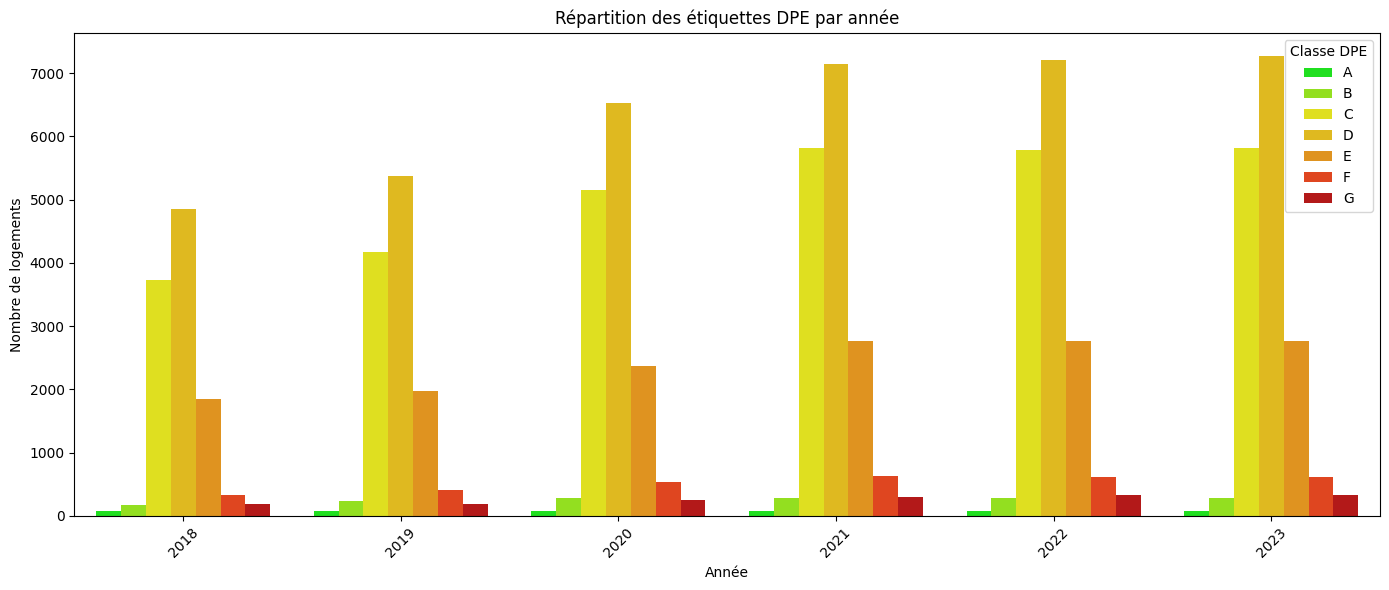

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nettoyage et ordre des classes DPE
Data['Etiquette_DPE'] = pd.Categorical(Data['Etiquette_DPE'], categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)
df = Data.dropna(subset=['Etiquette_DPE', 'Année_y'])

# Palette de couleurs pour les classes DPE
dpe_palette = {
    'A': '#00FF00',
    'B': '#99FF00',
    'C': '#FFFF00',
    'D': '#FFCC00',
    'E': '#FF9900',
    'F': '#FF3300',
    'G': '#CC0000'
}

# Répartition des DPE par année
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='Année_y', hue='Etiquette_DPE', palette=dpe_palette)
plt.title("Répartition des étiquettes DPE par année")
plt.xlabel("Année")
plt.ylabel("Nombre de logements")
plt.legend(title="Classe DPE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📊 Consommation moyenne par classe DPE

C:\Users\msi\AppData\Local\Temp\ipykernel_20596\3103380141.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Etiquette_DPE', y='Conso_5_usages', palette=dpe_palette, showfliers=False)


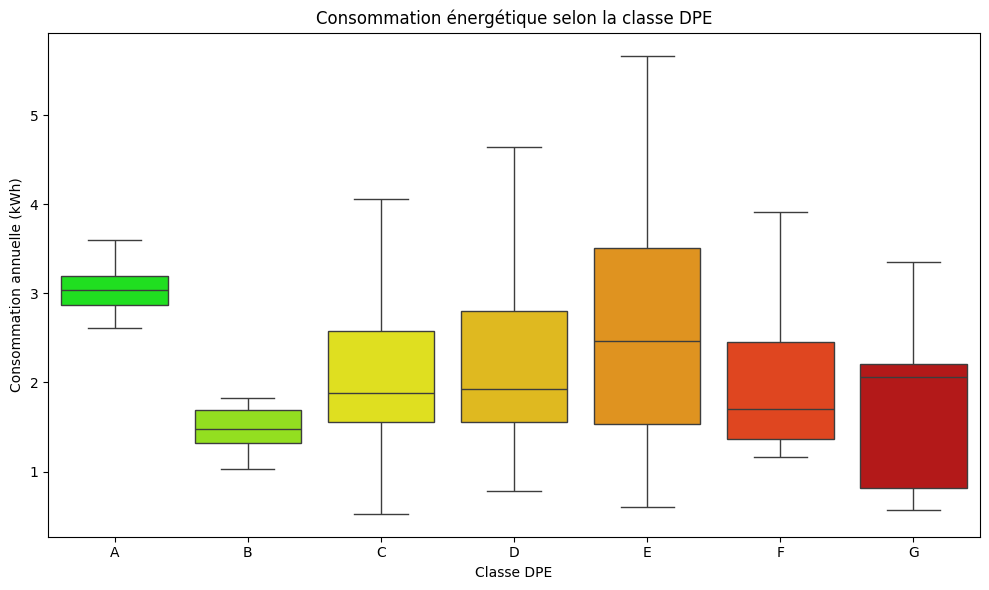

In [12]:
# Moyenne de consommation par classe DPE
df = df.dropna(subset=['Consommation annuelle moyenne par logement de l\'adresse (MWh)'])
df['Conso_5_usages'] = df['Consommation annuelle moyenne par logement de l\'adresse (MWh)'] 

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Etiquette_DPE', y='Conso_5_usages', palette=dpe_palette, showfliers=False)
plt.title("Consommation énergétique selon la classe DPE")
plt.xlabel("Classe DPE")
plt.ylabel("Consommation annuelle (kWh)")
plt.tight_layout()
plt.show()


La classe A montre une consommation moyenne élevée (3 kWh) plutôt qu'une basse consommation attendue.
La classe B présente la consommation la plus faible et stable.
Les classes suivent un ordre inattendu : la classe E a la consommation la plus élevée, pas la G.
La classe E montre la plus grande variabilité avec des valeurs extrêmes élevées.
La classe G a une médiane basse mais une grande dispersion des valeurs.
Cette distribution contredit la logique habituelle du DPE où A devrait consommer moins que G.

In [15]:
import plotly.express as px
import webbrowser

fig = px.histogram(
    df,
    x='Année_y',
    color='Etiquette_DPE',
    category_orders={'Etiquette_DPE': ['A', 'B', 'C', 'D', 'E', 'F', 'G']},
    color_discrete_map=dpe_palette,
    title="Répartition interactive des classes DPE par année"
)
fig.update_layout(barmode='stack', xaxis_title="Année", yaxis_title="Nombre de logements")

# ✅ Solution de contournement : export HTML
fig.write_html("graph_dpe.html")
webbrowser.open("graph_dpe.html")

True

### Heatmap (DPE × Région)

C:\Users\msi\AppData\Local\Temp\ipykernel_4664\2147937482.py:1: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



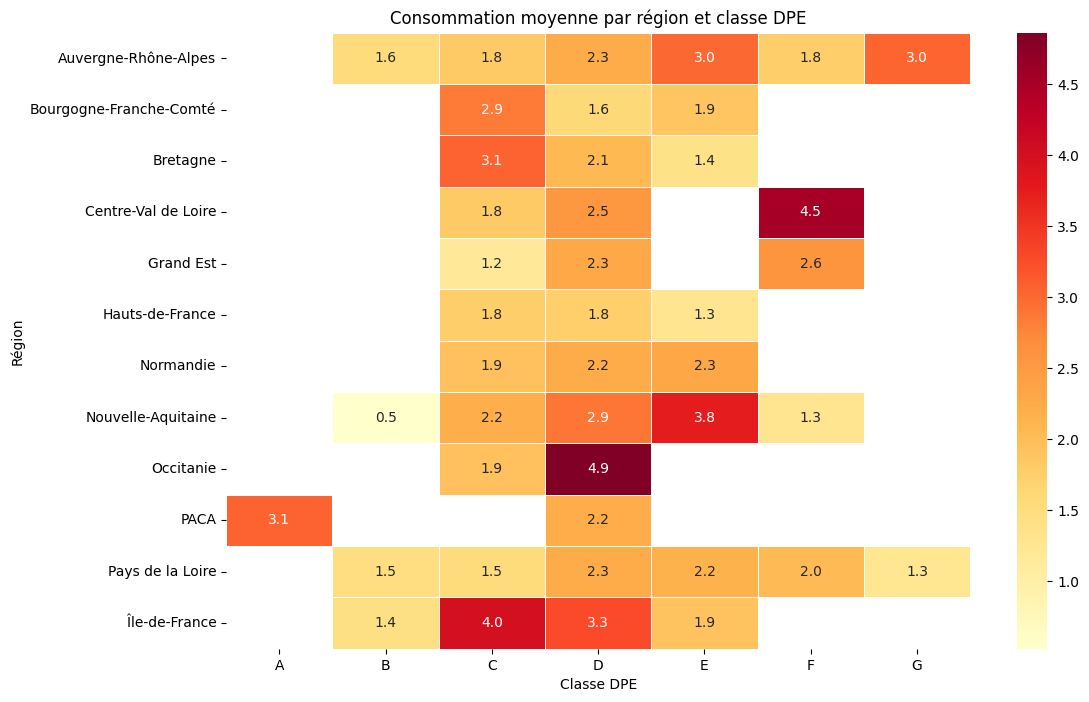

In [17]:
pivot_region = Data.pivot_table(
    index='Nom de region',
    columns='Etiquette_DPE',
    values=col_conso,
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_region[dpe_order],  # Ordonné A-G
    cmap='YlOrRd',
    annot=True,
    fmt='.1f',
    linewidths=0.5
)
plt.title('Consommation moyenne par région et classe DPE')
plt.xlabel('Classe DPE')
plt.ylabel('Région')
plt.show()

L'Occitanie a le point le plus élevé avec 4,9 kWh pour la classe C.
Le Centre-Val de Loire a une forte consommation (4,5 kWh) en classe E.
L'Île-de-France montre une consommation élevée (4,0 kWh) pour la classe C.
La Nouvelle-Aquitaine présente la consommation la plus basse (0,5 kWh) en classe A.
Les classes C et D ont généralement des consommations plus élevées que A et B dans la plupart des régions.
Les données sont incomplètes pour certaines régions et classes (cases blanches).
PACA montre un profil atypique avec seulement deux classes représentées (A et D).
Les Pays de la Loire ont la distribution la plus complète avec des données pour toutes les classes DPE.
La Bretagne présente une tendance décroissante de consommation des classes B à D.
Les Hauts-de-France montrent des consommations relativement basses dans toutes les classes représentées

### Courbe d'évolution temporelle


C:\Users\msi\AppData\Local\Temp\ipykernel_20596\406326987.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




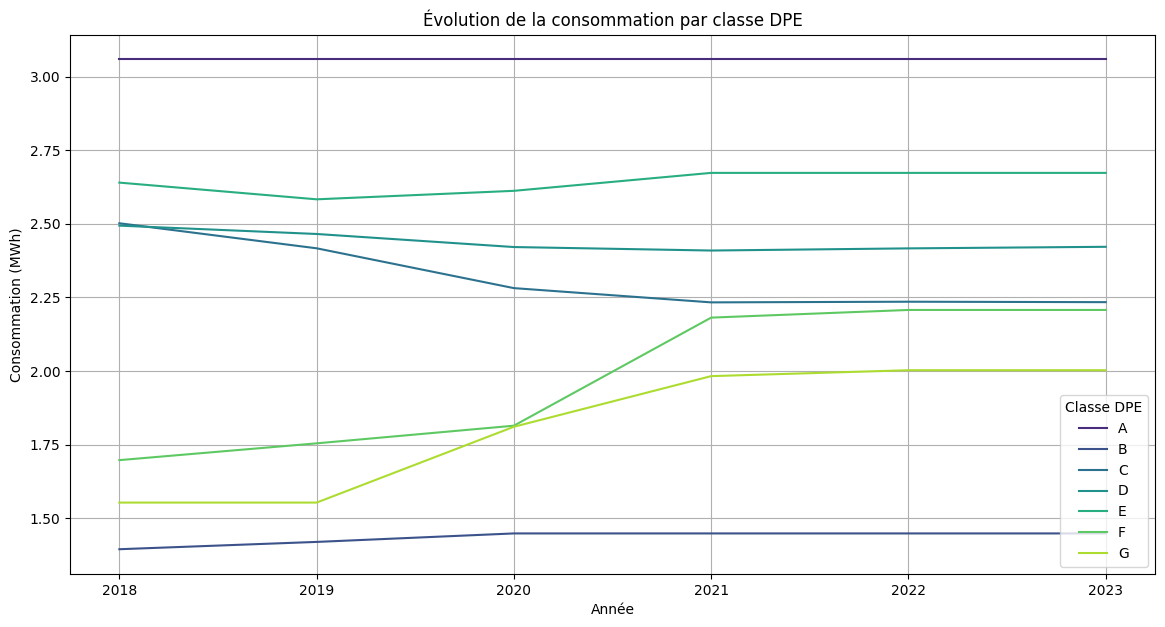

In [16]:
plt.figure(figsize=(14, 7))
sns.lineplot(
    x='Année_y',
    y=col_conso,
    hue='Etiquette_DPE',
    data=Data,
    palette='viridis',
    ci=None,
    hue_order=dpe_order
)
plt.title('Évolution de la consommation par classe DPE')
plt.xlabel('Année')
plt.ylabel('Consommation (MWh)')
plt.grid(True)
plt.legend(title='Classe DPE')
plt.show()

La classe A maintient la consommation la plus élevée (3 kWh) sur toute la période 2018-2023.
La classe B montre une baisse constante de 2,5 à 2,2 kWh.
Les classes F et G augmentent nettement entre 2019 et 2021.
Les classes D et C restent relativement stables avec légère baisse.
Ordre illogique : la classe A (censée être la plus efficace) consomme plus que la G.
Changements notables entre 2020-2021 pour plusieurs classes.
Stabilisation générale des tendances après 2021.